In [1]:
import networkx as nx
import numpy as np
from scipy import special
from scipy.spatial import distance
import seaborn as sns
from sklearn import metrics
import tqdm

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
digraph = nx.read_graphml('../../../scripture_graph.graphml')
print(digraph.number_of_nodes(), digraph.number_of_edges())
graph_lib.remove_topic_nodes(digraph)
print(digraph.number_of_nodes(), digraph.number_of_edges())
graph = digraph.to_undirected()
print(graph.number_of_nodes(), graph.number_of_edges())

48566 183072
41995 45985
41995 26946


In [3]:
# nx.jaccard_coefficient is too slow; we can roll our own with the adjacency matrix.
possible = special.comb(graph.number_of_nodes(), 2, exact=True) - graph.number_of_nodes()
print(graph.number_of_edges(), possible, graph.number_of_edges() / possible * 100)

26946 881727020 0.00305604789110353


In [4]:
a = nx.to_numpy_array(graph, dtype=bool)
print(a.shape)

(41995, 41995)


In [5]:
# What is the average number of connections?
total = a.sum(axis=1)
print(np.mean(total), np.median(total))
# now without the singletons
print(np.mean(total[total > 0]), np.median(total[total > 0]))

1.2832956304321943 0.0
2.7284325637910083 2.0


In [7]:
# Fold the vectors to speed up metric calculations.
features = np.zeros([len(a), 1024], dtype=bool)
for j in tqdm.tqdm(range(a.shape[1])):
    k = j % features.shape[1]
    features[:, k] = np.maximum(a[:, j], features[:, k])
del a  # Save memory.

100%|██████████| 41995/41995 [00:32<00:00, 1285.25it/s]


In [8]:
# scipy jaccard sets the distance to zero when there are no common neighbors
def jaccard(features):
    ab = np.matmul(features, features.T, dtype=int)
    aa = features.sum(axis=1, keepdims=True)
    bb = aa.T
    return ab / (aa + bb - ab)

In [10]:
a = nx.adjacency_matrix(graph)
type(a)

scipy.sparse.csr.csr_matrix

In [15]:
%%time
ab = a @ a.T
aa = a.sum(axis=1)
bb = aa.T
s = ab / (aa + bb - ab)
print(s.shape)

(41995, 41995)
CPU times: user 4.54 s, sys: 5.46 s, total: 9.99 s
Wall time: 9.99 s


In [22]:
s = np.nan_to_num(s, copy=False)
s[np.diag_indices_from(s)] = 0

In [ ]:
%%time
d = jaccard(features)

In [ ]:
sq = distance.squareform(d)
nz = sq[sq > 0]
print(sq.shape, nz.shape)

In [ ]:
sns.displot(nz, kind='ecdf')

(881769015,)


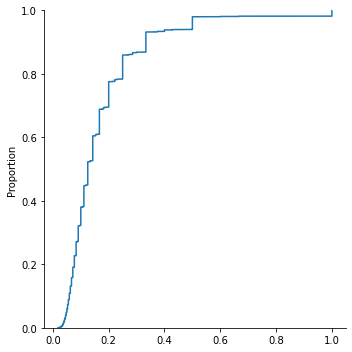

In [23]:
nz = distance.squareform(s)
print(nz.shape)
sns.displot(nz[nz > 0], kind='ecdf')

In [ ]:
sns.displot(nz, kind='ecdf')